In [1]:
import kaggle
import pandas
import os
import re
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
import os
import warnings
import kaggle
from data_preprocessing import CustomImageDataset
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

In [2]:
def download_data(path):
	if os.path.isdir(path):
		warnings.warn("Directory already exists. Download skipped, but the code continues!", UserWarning)
	else:
		kaggle.api.dataset_download_files(
			"tongpython/cat-and-dog", path=path, unzip=True
		)
		print("Data downloaded and unzipped to:", path)

In [3]:
path = './data/'
download_data(path)

/var/folders/c6/bflj7jtn117gmc20cqnz2sg40000gn/T/ipykernel_18123/1694732625.py:3: UserWarning: Directory already exists. Download skipped, but the code continues!
  warnings.warn("Directory already exists. Download skipped, but the code continues!", UserWarning)


In [4]:
def plot_samples(samples, title: str = None):

	num_cols = 5
	num_rows = ((len(samples) - 1) // num_cols) + 1
	fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

	axes = axes.flatten()

	for index, sample in enumerate(samples):
		image = mpimg.imread(sample)
		axes[index].imshow(image)
		axes[index].axis("off")

	if title:
		fig.suptitle(title, fontsize=16, y=0.8)

	plt.tight_layout()
	plt.show()


def get_examples(num_samples: int):

	for animal in ["dogs", "cats"]:
		base_path = f"./data/training_set/training_set/{animal}/"
		files = os.listdir(base_path)
		images = [file for file in files if re.search(r"\.jpe?g$", file, re.IGNORECASE)]
		samples = random.sample(images, k=num_samples)
		samples = [base_path + sample for sample in samples]

		title = f'{animal} examples'
		plot_samples(samples, title=title)

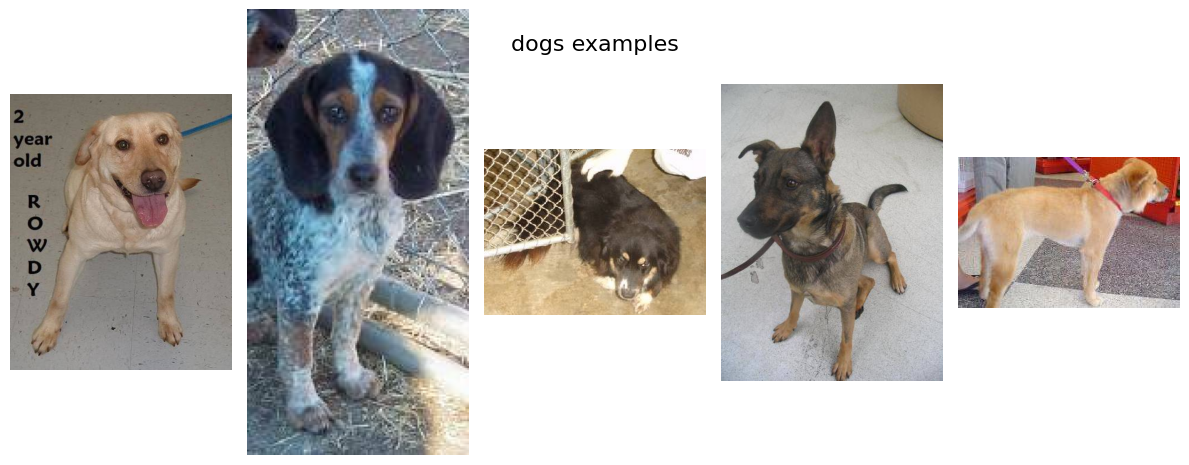

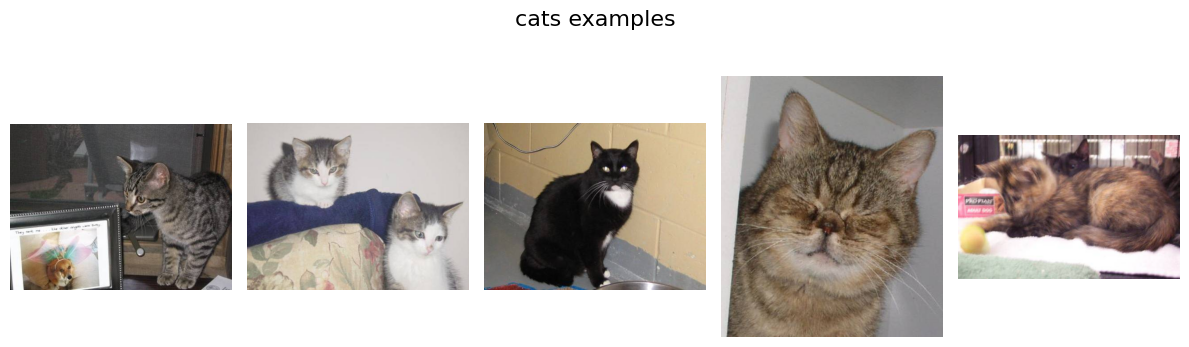

In [5]:
get_examples(5)

In [6]:
def get_statistics(path):

	total_count = 0
	animals = os.listdir(path)
	for index, animal in enumerate(animals):
		base_path = f"./data/training_set/training_set/{animal}/"

		if not os.path.exists(base_path):
			print(f"Directory not found for {animal}: {base_path}")
			continue

		file_paths = os.listdir(base_path)
		image_paths = [
			file_path
			for file_path in file_paths
			if re.search(r"\.jpe?g$", file_path, re.IGNORECASE)
		]
		updated_image_paths = [base_path + image_path for image_path in image_paths]

		print(f"Number of {animal}:", len(updated_image_paths))
		total_count += len(updated_image_paths)
		storage = dict()

		for image_path in updated_image_paths:

			with Image.open(image_path) as image:

				width, height = image.size
				storage[(width, height)] = storage.get((width, height), 0) + 1

		sorted_by_values = sorted(storage.items(), key=lambda x: x[1], reverse=True)[:3]
		print(f'Most common {animal} image shapes:')

		for value in sorted_by_values:
			width, height, count = value[0][0], value[0][1], value[1]
			print(f'width: {width}, height: {height}, count: {count}')
		
		print('')
		if index == len(animals)-1:
			print('Total Count:', total_count)
		
		


In [7]:
# Train Statistics
get_statistics('./data/training_set/training_set/')

# Test Statistics
get_statistics('./data/test_set/test_set/')

Number of dogs: 4005
Most common dogs image shapes:
width: 500, height: 374, count: 450
width: 499, height: 375, count: 423
width: 375, height: 499, count: 45

Number of cats: 4000
Most common cats image shapes:
width: 499, height: 375, count: 506
width: 500, height: 374, count: 490
width: 499, height: 333, count: 48

Directory not found for .DS_Store: ./data/training_set/training_set/.DS_Store/
Number of dogs: 4005
Most common dogs image shapes:
width: 500, height: 374, count: 450
width: 499, height: 375, count: 423
width: 375, height: 499, count: 45

Number of cats: 4000
Most common cats image shapes:
width: 499, height: 375, count: 506
width: 500, height: 374, count: 490
width: 499, height: 333, count: 48

Total Count: 8005


Images Shape: torch.Size([2, 3, 512, 512])
Labels Shape: torch.Size([2, 2])
Example Image:


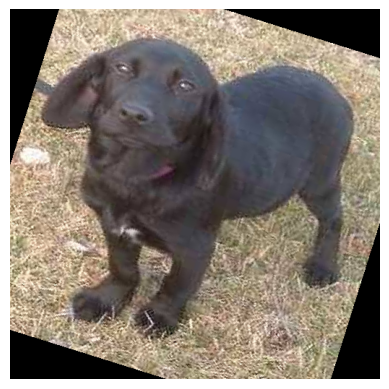

Image Class: tensor([1., 0.])


In [9]:
transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.LANCZOS),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=45)
])

train_directory_path = f"./data/training_set/training_set/"
test_directory_path = f"./data/test_set/test_set/"

full_dataset = CustomImageDataset(directory_path=train_directory_path, transform=transform)
test_dataset = CustomImageDataset(directory_path=test_directory_path, transform=None)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=2, shuffle=True, num_workers=1)
val_loader = DataLoader(dataset=val_dataset, batch_size=2, shuffle=True, num_workers=1)

for images, labels in train_loader:
	print('Images Shape:', images.shape)
	print('Labels Shape:', labels.shape)

	image = images[0].permute(1, 2, 0).numpy() 
	label = labels[0]

	print('Example Image:')
	plt.imshow(image)
	plt.axis('off')
	plt.show()
	print('Image Class:', label)
	break

In [10]:
import torch.nn as F
from torch.nn import Conv2d, ReLU, Sigmoid, ReLU, Linear, AdaptiveAvgPool2d, BatchNorm2d, Softmax
import torch.nn as nn

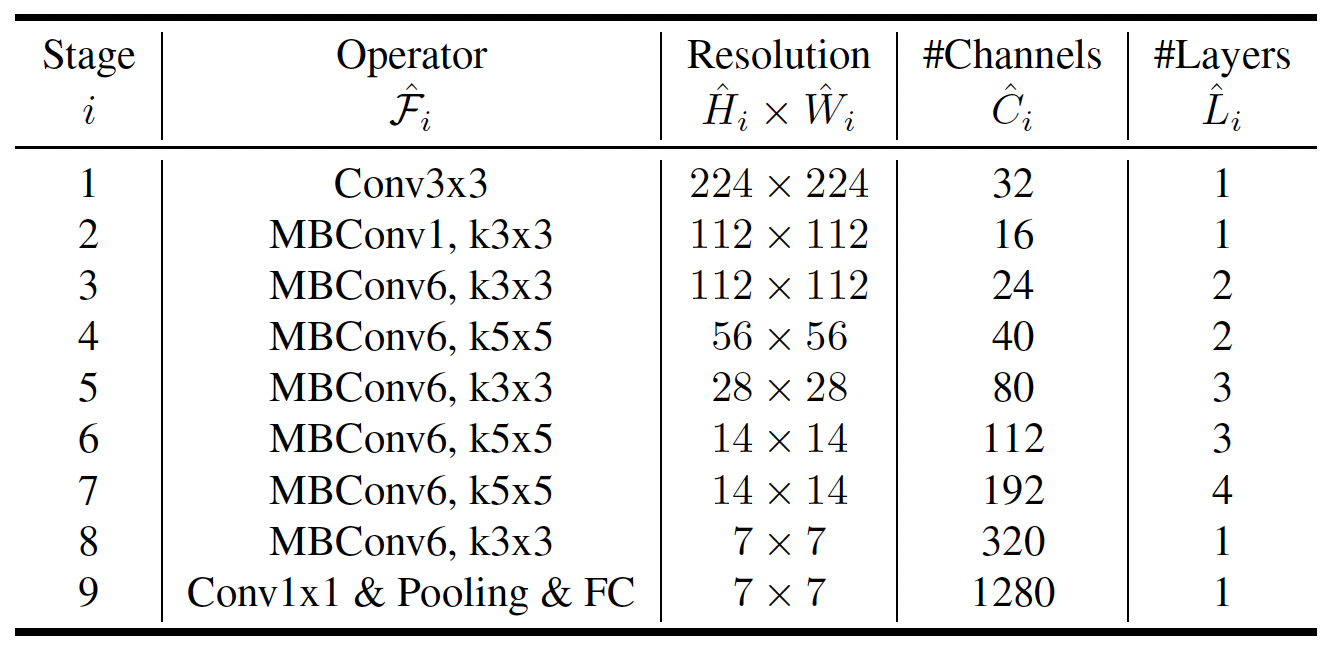

In [11]:
img = Image.open('./source_images/efficient_net_b0.png')
img

In [12]:
class SE(nn.Module):
	def __init__(self, input_channels, reduction_rate=16):
		super(SE, self).__init__()
		self.global_avg_pool = AdaptiveAvgPool2d(1)
		
		reduction_dim = max(1, input_channels // reduction_rate)

		self.fc1 = Linear(
			in_features=input_channels, 
			out_features=reduction_dim,
			bias=False
		)

		self.fc2 = Linear(
			in_features=reduction_dim,
			out_features=input_channels,
			bias=False
		)
		
		self.sigmoid = Sigmoid()

		self.swish = lambda x: x * self.sigmoid(x)

	
	def forward(self, x):
		batch_size, channels, _, _ = x.size()
		
		y = self.global_avg_pool(x).view(batch_size, channels) 
		
		y = self.swish(self.fc1(y)) 
		y = self.sigmoid(self.fc2(y))
		
		y = y.view(batch_size, channels, 1, 1) 

		return x * y  


class MBConv(nn.Module):
	def __init__(self, input_channels, output_channels, kernel_size, padding, expansion_ratio, stride, squeeze:bool=False, reduction_rate:int=16):
		super().__init__()

		# Expansion
		self.expansion_ratio = expansion_ratio 
		self.input_channels = input_channels
		self.output_channels = output_channels
		self.hidden_channels = int(input_channels * expansion_ratio)

		self.expansion_conv = Conv2d(
			in_channels=self.input_channels,
			out_channels=self.hidden_channels,
			kernel_size=1,
			stride=1,
			bias=False
		)
		
		self.expansion_normalisation = BatchNorm2d(
			num_features=self.hidden_channels
		)

		# Depthwise convolution
		self.stride = stride
		self.kernel_size = kernel_size
		self.padding = padding
		self.depthwise_conv = Conv2d(
			in_channels=self.hidden_channels,
			out_channels=self.hidden_channels,
			groups=self.hidden_channels,
			kernel_size=self.kernel_size,
			padding=self.padding,
			stride=stride,
			bias=True
		)

		self.depthwise_normalisation = BatchNorm2d(
			num_features=self.hidden_channels
		)

		# Squeeze and excitation
		self.squeeze = squeeze
		if self.squeeze:
			self.squeeze_and_excitation = SE(
				self.hidden_channels,
				reduction_rate=reduction_rate
			)

		# Pointwise Convolution
		self.output_channels = output_channels
		self.pointwise_conv = Conv2d(
			in_channels=self.hidden_channels,
			out_channels=output_channels,
			kernel_size=1,
			stride=1,
			bias=False
		)

		self.pointwise_normalisation = BatchNorm2d(
			num_features=output_channels
		)
		
		self.sigmoid = Sigmoid()
		self.swish = lambda x: x * self.sigmoid(x)

	def forward(self, x):

		x = self.expansion_conv(x)
		x = self.expansion_normalisation(x)
		x = self.swish(x)

		x = self.depthwise_conv(x)
		x = self.depthwise_normalisation(x)
		x = self.swish(x)

		if self.squeeze:
			x = self.squeeze_and_excitation(x)

		x = self.pointwise_conv(x)
		x = self.pointwise_normalisation(x)
		x = self.swish(x)

		return x
		


class efficient_net_b0(nn.Module):

	def __init__(self):
		super().__init__()

		self.depth = 16
		self.num_classes = 2
		self.output_channels = [16] + (2 * [24]) + (2 * [40]) + (3 * [80]) + (3 * [112]) + (4 * [192]) + [320]
		self.input_channels = [32] + self.output_channels[:-1]
		self.strides = [1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1]
		self.kernel_sizes = (3 * [3])  + (2 * [5]) + (3 * [3]) + (7 * [5]) + (1 * [3])

		self.basic_conv = Conv2d(
			in_channels=3, 
			out_channels=32,
			kernel_size=3,
			stride=2,
			padding=1,
			bias=True,
		)

		self.final_conv = Conv2d(
			in_channels=self.output_channels[-1],
			out_channels=1280,
			kernel_size=1,
			stride=1,
			bias=True
		)
		self.final_norm = BatchNorm2d(1280)

		self.global_avg_pool = AdaptiveAvgPool2d(1)

		self.fc = Linear(
			in_features=1280, 
			out_features=self.num_classes,
			bias=False
		)

		self.softmax = Softmax()
		

	def forward(self, x):

		x = self.basic_conv(x)
		
		for i in range(self.depth):
			mb_conv = MBConv(
				input_channels=self.input_channels[i],
				output_channels=self.output_channels[i],
				kernel_size=self.kernel_sizes[i],
				expansion_ratio=6,
				stride=self.strides[i],
				padding=self.kernel_sizes[i]//2,
				squeeze=True,
				reduction_rate=16
				)
			x = mb_conv(x)

		x = self.final_conv(x)
		x = self.final_norm(x)
		
		x = self.global_avg_pool(x)
		x = x.view(x.size(0), -1)
		
		x = self.fc(x)
		x = self.softmax(x)

		return x

In [13]:
import time
import torch
start_time = time.time()
model = efficient_net_b0()
dummy_input = torch.randn(2, 3, 224, 224)
output = model(dummy_input)
print(time.time()-start_time)
print(output)

0.44631314277648926
tensor([[0.5174, 0.4826],
        [0.4826, 0.5174]], grad_fn=<SoftmaxBackward0>)


/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torch/nn/modules/module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
total_params

416896

In [15]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0(pretrained=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f'Total number of parameters in official EfficientNet-B0: {total_params}')

Total number of parameters in official EfficientNet-B0: 5288548


/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/benbradshaw/Documents/Code/2023/dogs_vs_cats_2/myenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
import torch.nn.functional as F

In [23]:
def train_model(model, optimizer, scheduler, train_loader, val_loader, model_path, epochs:int, seed=42, patience:int=15, threshold:int=1e-4):

	min_delta = 1e-4 
	best_loss = float('inf')
	start_time = time.time()
	criterion = torch.nn.BCELoss()

	for epoch in range(epochs):
		epoch_start_time = time.time()
		model.train()
		
		outputs_tensor, labels_tensor = torch.empty(1,2), torch.empty(1,2)
		counter, running_loss = 0, 0
		for batch in tqdm(train_loader):
			features = batch[0]
			labels = batch[1]
			counter += 1

			optimizer.zero_grad()
			
			outputs = model(features)

			print(outputs.size(), labels.size())
			loss_train = criterion(outputs, labels)

			running_loss += loss_train
			outputs_tensor = torch.cat((outputs_tensor, outputs), dim=0)
			labels_tensor = torch.cat((labels_tensor, labels), dim=0)

			loss_train.backward()
			optimizer.step()
		
		train_loss = running_loss/counter
		train_acc = accuracy(outputs_tensor, labels_tensor)

		model.eval()
		outputs_tensor, labels_tensor = torch.empty(1,2), torch.empty(1)
		counter, running_loss = 0, 0
		with torch.no_grad():
			for batch in val_loader:
				features = batch[0]
				labels = batch[1]
				counter += 1

				outputs = model(features)

				outputs_tensor = torch.cat((outputs_tensor, outputs), dim=0)
				labels_tensor = torch.cat((labels_tensor, labels), dim=0)

				running_loss += criterion(outputs, labels)
			
		val_loss = running_loss / counter
		val_acc = accuracy(outputs_tensor, labels_tensor)

		# Changing step sizes
		current_lr = optimizer.param_groups[0]['lr']
		scheduler.step(val_loss)
		new_lr = optimizer.param_groups[0]['lr']
		if new_lr != current_lr:
			print(f'Epoch {epoch}: Learning rate reduced from {current_lr} to {new_lr}')
		
		# Early stopping criterion
		if val_loss.item() < best_loss - threshold:
			best_loss = val_loss.item()
			best_model_state = model.state_dict()
			torch.save(best_model_state, model_path)
			early_stop_counter = 0
		else:
			early_stop_counter += 1
			if early_stop_counter >= patience:
				break

		new_row = pd.DataFrame({'epoch': epoch+1, 'train_loss': [train_loss.item()],'train_acc': [train_acc], 'val_loss':[val_loss.item()], 'val_acc':[val_acc]})

		history_path = './history/history.csv'
		if epoch == 0 and os.path.isfile(history_path):
			os.remove(history_path)
			new_row.to_csv(history_path, mode='a', header=True, index=False)
		else:
			new_row.to_csv(history_path, mode='a', header=False, index=False)

		if ((epoch+1) % 1) == 0:
			print('Epoch: {:04d}'.format(epoch + 1),
			'loss_train: {:.4f}'.format(train_loss.item()),
			'acc_train: {:.4f}'.format(train_acc),
			'loss_val: {:.4f}'.format(val_loss.item()),
			'acc_val: {:.4f}'.format(val_acc),
			'time: {:.4f}s'.format(time.time() - epoch_start_time))
			

	t_total = time.time()
    
	print("Optimization Finished!")
	print("Total time elapsed: {:.4f}s".format(time.time() - start_time))



def test_model(model, test_loader):
	model.eval()

	outputs_tensor, labels_tensor = torch.empty(1,2), torch.empty(1)
	counter, running_loss = 0, 0
	with torch.no_grad():
		for batch in test_loader:
			labels = batch.y.squeeze().long()
			counter += 1

			outputs = model(batch)

			outputs_tensor = torch.cat((outputs_tensor, outputs), dim=0)
			labels_tensor = torch.cat((labels_tensor, labels), dim=0)

			running_loss += F.nll_loss(outputs, labels)
	
	
	test_loss = F.nll_loss(outputs, labels)
	test_acc = accuracy(outputs_tensor, labels_tensor)
	test_precision, test_recall, test_f1 = precision_recall_f1(outputs_tensor, labels_tensor)
	
	#f1_test = f1_metric(outputs, labels)
	print("Test set results:",
		"loss= {:.4f}".format(test_loss.item()),
		"accuracy= {:.4f}".format(test_acc),
		"recall= {:.4f}".format(test_recall),
		"precision= {:.4f}".format(test_precision),
		"f1= {:.4f}".format(test_f1))

In [24]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import numpy as np

In [25]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model_path = './model/model_weights.pth'

model = efficient_net_b0()

pytorch_total_params = sum(p.numel() for p in model.parameters())
print('Number of Parameters:', pytorch_total_params)

optimizer = torch.optim.Adam(
	params=model.parameters(),
	lr=1e-4
)

scheduler = ReduceLROnPlateau(
	optimizer,
	'min',
	factor=0.1,
	min_lr=1e-6
)

train_model(
	model,
	optimizer,
	scheduler=scheduler,
	train_loader=train_loader,
	val_loader=val_loader,
	model_path=model_path,
	epochs=200,
	patience=25,
	threshold=1e-4
)

Number of Parameters: 416896


  0%|                                                  | 0/3202 [00:00<?, ?it/s]

torch.Size([2, 2]) torch.Size([2, 2])


  0%|                                       | 1/3202 [00:12<11:06:23, 12.49s/it]

torch.Size([2, 2]) torch.Size([2, 2])


  0%|                                        | 2/3202 [00:16<6:35:09,  7.41s/it]

torch.Size([2, 2]) torch.Size([2, 2])


  0%|                                        | 3/3202 [00:20<5:07:10,  5.76s/it]

torch.Size([2, 2]) torch.Size([2, 2])


  0%|                                        | 4/3202 [00:23<4:17:34,  4.83s/it]

torch.Size([2, 2]) torch.Size([2, 2])


  0%|                                        | 4/3202 [00:27<6:01:44,  6.79s/it]


KeyboardInterrupt: 